Team Members:

*   Francis, Rikky Linuz - UTA ID: 1001753137
*   Mukka, Himaneesh - UTA ID: 1001861524
*   Smitherman, Samuel M - UTA ID: 1000762170

Link of the google colab: 
https://colab.research.google.com/drive/1j3g3FXqZxQw3WndkoPb_JpoScS6QdXYb?usp=sharing

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import warnings
import math

from keras import Sequential, Model, regularizers, utils
from keras.layers import Embedding, LSTM, Dense, Input, Bidirectional, RepeatVector, Concatenate, Activation
from keras.layers import Dropout, Conv1D, Conv2D, concatenate, MaxPooling1D, MaxPooling2D, Flatten, Embedding, Lambda, GRU, BatchNormalization
from keras import backend as K
from keras.activations import softmax
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.optimizers import Adam, SGD, RMSprop
from os import listdir
from os.path import isfile, isdir, join
from random import shuffle
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

drive.mount('/content/gdrive')

Mounted at /content/drive
Mounted at /content/gdrive


# Data Pre-Processing

In [ ]:
csv_dir = "/content/gdrive/MyDrive/gtzan_dataset/"
music_dir ="/content/gdrive/MyDrive/gtzan_dataset/genres_original/"

In [ ]:
def createSpectrogram(path, divided, segment):
  y, sr = librosa.load(path)

  if(divided == True):
    samplesPerTrack = 22050 * 30
    samplesPerSegment = int(samplesPerTrack / 5)
    spectrogramsPerSegment = math.ceil(samplesPerSegment / 512)

    start = samplesPerSegment * segment
    finish = start + samplesPerSegment
    y = y[start:finish]
    
  spect = librosa.feature.melspectrogram(
      y=y, sr=sr, n_mels=128, n_fft=2048, hop_length=512)
  
  spect = librosa.core.pcen(
      spect, sr=sr, hop_length=512, gain=0.6, bias=0.1,
      power=0.2, time_constant=0.4, eps=1e-9)
    
  return spect.T

In [ ]:
def createMFCC(path, divided, segment):
  y, sr = librosa.load(path)

  if(divided == True):
    samplesPerTrack = 22050 * 30
    samplesPerSegment = int(samplesPerTrack / 5)
    spectrogramsPerSegment = math.ceil(samplesPerSegment / 512)

    start = samplesPerSegment * segment
    finish = start + samplesPerSegment
    y = y[start:finish]
  
  mfcc = librosa.feature.mfcc(
      y=y, sr=sr, n_fft=2048, hop_length=512)
    
  return mfcc.T

In [ ]:
mainDirectory = [directory for directory in listdir(music_dir) if isdir(join(music_dir, directory))]

mainDirectory.sort()

print(mainDirectory)

filePaths = []
trackGenres = []

for directory in mainDirectory:
  musicFiles = [fileName for fileName in listdir(join(music_dir, directory))]

  for mf in musicFiles:
    filePaths.append(music_dir + directory + "/" + mf)
    trackGenres.append(directory)

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


(1293, 128)


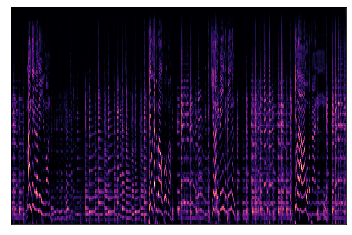

In [ ]:
spect = createSpectrogram(filePaths[0], False, 0)
librosa.display.specshow(spect.T)
print(spect.shape)

(1293, 20)


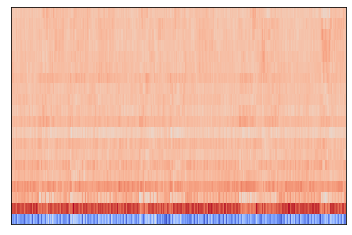

In [ ]:
mfcc = createMFCC(filePaths[12], False, 0)
librosa.display.specshow(mfcc.T)
print(mfcc.shape)

In [ ]:
genres = mainDirectory

genreID = {}
genreMap = {}

trackGenreIDs = []

i = 0
for genre in genres:
  genreID[genre] = [i]
  genreMap[i] = genre
  i += 1

# Mel-Spectrogram

In [ ]:
spectrograms = np.empty((0, 640, 128))

i = 0
for path in filePaths:
  with warnings.catch_warnings():
    try:
      warnings.simplefilter("ignore")
      spect = createSpectrogram(path, False, 0)
      spect = spect[:640, :]
      spectrograms = np.append(spectrograms, [spect], axis=0)
      trackGenreIDs.append(genreID[trackGenres[i]])
    except:
      continue
  i += 1
  
print(len(spectrograms))
print(trackGenreIDs)

999
[[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], 

In [ ]:
XSpec = spectrograms
ySpec = np.array(trackGenreIDs)

print(XSpec.shape)
print(ySpec.shape)

(999, 640, 128)
(999, 1)


In [ ]:
np.save("gdrive/MyDrive/CSE5368/gtzan_X_spec.npy", XSpec)
np.save("gdrive/MyDrive/CSE5368/gtzan_y_spec.npy", ySpec)

In [ ]:
XSpec = np.load("gdrive/MyDrive/CSE5368/gtzan_X_spec.npy")
ySpec = np.load("gdrive/MyDrive/CSE5368/gtzan_y_spec.npy")

In [ ]:
X_train_spec, X_test_spec, y_train_spec, y_test_spec = train_test_split(XSpec, ySpec, test_size=0.3, stratify=ySpec)

In [ ]:
X_train_spec, X_valid_spec, y_train_spec, y_valid_spec = train_test_split(X_train_spec, y_train_spec, test_size=0.2)

In [ ]:
np.save("gdrive/MyDrive/CSE5368/gtzan_X_train_spec.npy", X_train_spec)
np.save("gdrive/MyDrive/CSE5368/gtzan_X_test_spec.npy", X_test_spec)
np.save("gdrive/MyDrive/CSE5368/gtzan_X_valid_spec.npy", X_valid_spec)
np.save("gdrive/MyDrive/CSE5368/gtzan_y_train_spec.npy", y_train_spec)
np.save("gdrive/MyDrive/CSE5368/gtzan_y_test_spec.npy", y_test_spec)
np.save("gdrive/MyDrive/CSE5368/gtzan_y_valid_spec.npy", y_valid_spec)

In [ ]:
X_train_spec = np.load("gdrive/MyDrive/CSE5368/gtzan_X_train_spec.npy")
X_test_spec = np.load("gdrive/MyDrive/CSE5368/gtzan_X_test_spec.npy")
X_valid_spec = np.load("gdrive/MyDrive/CSE5368/gtzan_X_valid_spec.npy")
y_train_spec = np.load("gdrive/MyDrive/CSE5368/gtzan_y_train_spec.npy")
y_test_spec = np.load("gdrive/MyDrive/CSE5368/gtzan_y_test_spec.npy")
y_valid_spec = np.load("gdrive/MyDrive/CSE5368/gtzan_y_valid_spec.npy")

In [ ]:
y_train_spec_category = to_categorical(y_train_spec)
y_test_spec_category = to_categorical(y_test_spec)
y_valid_spec_category = to_categorical(y_valid_spec)

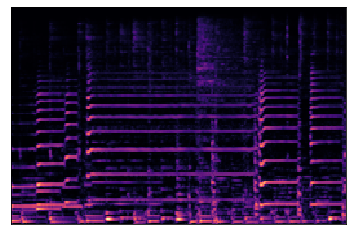

In [ ]:
librosa.display.specshow(X_train_spec[0].T)

In [ ]:
inputShape = (None,  128)
inputLayer = Input(shape=inputShape)

#Input Layer
layer = inputLayer

# Convolutional Layers
for i in range(3):
  layer = Conv1D(filters=3, kernel_size=5)(layer)
  layer = BatchNormalization()(layer)
  layer = Activation('relu')(layer)
  layer = MaxPooling1D(2)(layer)

# LSTM Layer
layer = LSTM(96, return_sequences=True)(layer)
layer = LSTM(64)(layer)

# Fully connected layer
layer = Dense(32)(layer)
layer = Dense(10)(layer)
layer = Activation('softmax')(layer)

pred = layer

model = Model(inputs=inputLayer, outputs=pred)

opt = RMSprop(lr=0.00075)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 128)]       0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 3)           1923      
_________________________________________________________________
batch_normalization (BatchNo (None, None, 3)           12        
_________________________________________________________________
activation (Activation)      (None, None, 3)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 3)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 3)           48        
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 3)           12    

In [ ]:
history = model.fit(x=X_train_spec, y=y_train_spec_category, batch_size=32, epochs=75, validation_data=(X_valid_spec, y_valid_spec_category), verbose=True)

Epoch 1/75
18/18 [==============================] - 37s 91ms/step - loss: 2.2037 - accuracy: 0.1382 - val_loss: 2.2643 - val_accuracy: 0.1143
Epoch 2/75
18/18 [==============================] - 0s 23ms/step - loss: 1.9675 - accuracy: 0.2324 - val_loss: 2.2549 - val_accuracy: 0.1929
Epoch 3/75
18/18 [==============================] - 0s 22ms/step - loss: 1.9368 - accuracy: 0.2028 - val_loss: 2.2273 - val_accuracy: 0.2357
Epoch 4/75
18/18 [==============================] - 0s 22ms/step - loss: 1.8764 - accuracy: 0.2423 - val_loss: 2.2287 - val_accuracy: 0.1143
Epoch 5/75
18/18 [==============================] - 0s 22ms/step - loss: 1.8152 - accuracy: 0.3391 - val_loss: 2.3328 - val_accuracy: 0.1214
Epoch 6/75
18/18 [==============================] - 0s 22ms/step - loss: 1.7561 - accuracy: 0.3256 - val_loss: 2.0382 - val_accuracy: 0.2000
Epoch 7/75
18/18 [==============================] - 0s 22ms/step - loss: 1.7034 - accuracy: 0.3509 - val_loss: 2.3155 - val_accuracy: 0.1429
Epoch 8/75
1

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


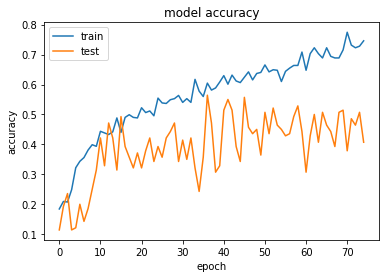

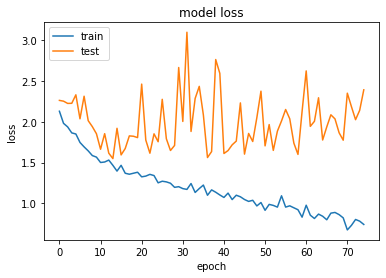

In [ ]:
def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

show_summary_stats(history)

In [ ]:
score = model.evaluate(X_test_spec, y_test_spec_category)

print("Loss")
print(score[0])
print("Acc")
print(score[1])

10/10 [==============================] - 0s 12ms/step - loss: 2.4445 - accuracy: 0.3933
Loss
2.444467544555664
Acc
0.3933333456516266


In [ ]:
from sklearn.metrics import classification_report

y_true = y_test_spec
y_pred = model.predict(X_test_spec)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4,5,6,7,8,9]
target_names = genreID.keys()

In [ ]:
print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

(300, 1) (300,)
              precision    recall  f1-score   support

       blues       0.31      0.17      0.22        30
   classical       0.79      0.87      0.83        30
     country       0.28      0.23      0.25        30
       disco       0.06      0.03      0.04        30
      hiphop       0.27      0.60      0.37        30
        jazz       0.52      0.53      0.52        30
       metal       0.80      0.27      0.40        30
         pop       0.44      0.37      0.40        30
      reggae       0.38      0.57      0.45        30
        rock       0.30      0.30      0.30        30

    accuracy                           0.39       300
   macro avg       0.41      0.39      0.38       300
weighted avg       0.41      0.39      0.38       300



In [ ]:
spectrograms = np.empty((0, 259, 128))

samplesPerTrack = 22050 * 30
samplesPerSegment = int(samplesPerTrack / 5)
spectrogramsPerSegment = math.ceil(samplesPerSegment / 512)

trackGenreIDs = []

i = 0
for path in filePaths:
  with warnings.catch_warnings():
    try:
      warnings.simplefilter("ignore")
      for j in range(5):
        spect = createSpectrogram(path, True, j)

        if(len(spect) == spectrogramsPerSegment):
          spectrograms = np.append(spectrograms, [spect], axis=0)
          trackGenreIDs.append(genreID[trackGenres[i]])
    except:
      continue
  i += 1
  
print(len(spectrograms))
print(trackGenreIDs)

4993
[[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0],

In [ ]:
XSpec5 = spectrograms
ySpec5 = np.array(trackGenreIDs)

print(XSpec5.shape)
print(ySpec5.shape)

(4993, 259, 128)
(4993, 1)


In [ ]:
np.save("gdrive/MyDrive/CSE5368/gtzan_X_spec5.npy", XSpec5)
np.save("gdrive/MyDrive/CSE5368/gtzan_y_spec5.npy", ySpec5)

In [ ]:
XSpec5 = np.load("gdrive/MyDrive/CSE5368/gtzan_X_spec5.npy")
ySpec5 = np.load("gdrive/MyDrive/CSE5368/gtzan_y_spec5.npy")

In [ ]:
print(ySpec5.shape)

(4993, 1)


In [ ]:
X_train_spec5, X_test_spec5, y_train_spec5, y_test_spec5 = train_test_split(
    XSpec5, ySpec5, test_size=0.3, stratify=ySpec5)

In [ ]:
X_train_spec5, X_valid_spec5, y_train_spec5, y_valid_spec5 = train_test_split(
    X_train_spec5, y_train_spec5, test_size=0.2)

In [ ]:
np.save("gdrive/MyDrive/CSE5368/gtzan_X_train_spec5.npy", X_train_spec5)
np.save("gdrive/MyDrive/CSE5368/gtzan_X_test_spec5.npy", X_test_spec5)
np.save("gdrive/MyDrive/CSE5368/gtzan_X_valid_spec5.npy", X_valid_spec5)
np.save("gdrive/MyDrive/CSE5368/gtzan_y_train_spec5.npy", y_train_spec5)
np.save("gdrive/MyDrive/CSE5368/gtzan_y_test_spec5.npy", y_test_spec5)
np.save("gdrive/MyDrive/CSE5368/gtzan_y_valid_spec5.npy", y_valid_spec5)

In [ ]:
X_train_spec5 = np.load("gdrive/MyDrive/CSE5368/gtzan_X_train_spec5.npy")
X_test_spec5 = np.load("gdrive/MyDrive/CSE5368/gtzan_X_test_spec5.npy")
X_valid_spec5 = np.load("gdrive/MyDrive/CSE5368/gtzan_X_valid_spec5.npy")
y_train_spec5 = np.load("gdrive/MyDrive/CSE5368/gtzan_y_train_spec5.npy")
y_test_spec5 = np.load("gdrive/MyDrive/CSE5368/gtzan_y_test_spec5.npy")
y_valid_spec5 = np.load("gdrive/MyDrive/CSE5368/gtzan_y_valid_spec5.npy")

In [ ]:
y_train_spec_category5 = to_categorical(y_train_spec5)
y_test_spec_category5 = to_categorical(y_test_spec5)
y_valid_spec_category5 = to_categorical(y_valid_spec5)

In [ ]:
inputShape = (None,  128)
inputLayer = Input(shape=inputShape)

#Input Layer
layer = inputLayer

# Convolutional Layers
for i in range(3):
  layer = Conv1D(filters=3, kernel_size=5)(layer)
  layer = BatchNormalization()(layer)
  layer = Activation('relu')(layer)
  layer = MaxPooling1D(2)(layer)
#  layer = Dropout(0.3)(layer)

# LSTM Layer
layer = LSTM(96, return_sequences=True)(layer)
layer = LSTM(64)(layer)

# Fully connected layer
layer = Dense(32)(layer)
layer = Dense(10)(layer)
layer = Activation('softmax')(layer)
#layer = Dropout(0.3)(layer)

pred = layer

model = Model(inputs=inputLayer, outputs=pred)

opt = RMSprop(lr=0.00075)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, 128)]       0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 3)           1923      
_________________________________________________________________
batch_normalization_3 (Batch (None, None, 3)           12        
_________________________________________________________________
activation_4 (Activation)    (None, None, 3)           0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 3)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 3)           48        
_________________________________________________________________
batch_normalization_4 (Batch (None, None, 3)           12  

In [ ]:
history = model.fit(x=X_train_spec5, y=y_train_spec_category5, batch_size=128, epochs=75, validation_data=(X_valid_spec5, y_valid_spec_category5), verbose=True)

Epoch 1/75
22/22 [==============================] - 5s 65ms/step - loss: 2.1619 - accuracy: 0.1762 - val_loss: 2.0997 - val_accuracy: 0.2189
Epoch 2/75
22/22 [==============================] - 1s 23ms/step - loss: 1.7564 - accuracy: 0.3361 - val_loss: 1.9051 - val_accuracy: 0.3119
Epoch 3/75
22/22 [==============================] - 1s 23ms/step - loss: 1.6065 - accuracy: 0.3880 - val_loss: 1.8661 - val_accuracy: 0.2403
Epoch 4/75
22/22 [==============================] - 0s 22ms/step - loss: 1.5208 - accuracy: 0.4223 - val_loss: 1.8527 - val_accuracy: 0.2704
Epoch 5/75
22/22 [==============================] - 1s 24ms/step - loss: 1.4675 - accuracy: 0.4445 - val_loss: 1.8117 - val_accuracy: 0.2775
Epoch 6/75
22/22 [==============================] - 1s 23ms/step - loss: 1.4313 - accuracy: 0.4496 - val_loss: 1.9005 - val_accuracy: 0.2561
Epoch 7/75
22/22 [==============================] - 1s 23ms/step - loss: 1.4363 - accuracy: 0.4639 - val_loss: 1.8210 - val_accuracy: 0.2346
Epoch 8/75
22

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


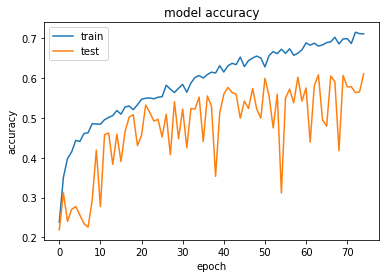

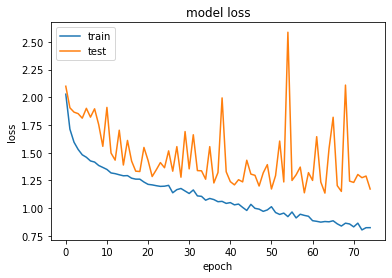

In [ ]:
def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

show_summary_stats(history)

In [ ]:
score = model.evaluate(X_test_spec5, y_test_spec_category5)

print("Loss")
print(score[0])
print("Acc")
print(score[1])

47/47 [==============================] - 0s 7ms/step - loss: 1.2779 - accuracy: 0.5794
Loss
1.2778931856155396
Acc
0.5794392228126526


In [ ]:
from sklearn.metrics import classification_report

y_true = y_test_spec5
y_pred = model.predict(X_test_spec5)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4,5,6,7,8,9]
target_names = genreID.keys()

In [ ]:
print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

(1498, 1) (1498,)
              precision    recall  f1-score   support

       blues       0.43      0.38      0.40       150
   classical       0.78      0.91      0.84       150
     country       0.37      0.49      0.42       150
       disco       0.58      0.59      0.59       150
      hiphop       0.70      0.53      0.60       150
        jazz       0.48      0.67      0.56       150
       metal       0.83      0.71      0.77       150
         pop       0.74      0.64      0.69       150
      reggae       0.56      0.52      0.54       150
        rock       0.45      0.35      0.39       148

    accuracy                           0.58      1498
   macro avg       0.59      0.58      0.58      1498
weighted avg       0.59      0.58      0.58      1498



# MFCC

In [ ]:
mfccs = np.empty((0, 640, 20))
trackGenreIDs = []

i = 0
for path in filePaths:
  with warnings.catch_warnings():
    try:
      warnings.simplefilter("ignore")
      mfcc = createMFCC(path, False, 0)
      mfcc = mfcc[:640, :]
      mfccs = np.append(mfccs, [mfcc], axis=0)
      trackGenreIDs.append(genreID[trackGenres[i]])
    except:
      continue
  i += 1
  
print(len(mfccs))

999


In [ ]:
XMFCC = mfccs
yMFCC = np.array(trackGenreIDs)

print(XMFCC.shape)
print(yMFCC.shape)

(999, 640, 20)
(999, 1)


In [ ]:
np.save("gdrive/MyDrive/CSE5368/gtzan_X_mfcc.npy", XMFCC)
np.save("gdrive/MyDrive/CSE5368/gtzan_y_mfcc.npy", yMFCC)

In [ ]:
XMFCC = np.load("gdrive/MyDrive/CSE5368/gtzan_X_mfcc.npy")
yMFCC = np.load("gdrive/MyDrive/CSE5368/gtzan_y_mfcc.npy")

In [ ]:
X_train_mfcc, X_test_mfcc, y_train_mfcc, y_test_mfcc = train_test_split(XMFCC, yMFCC, test_size=0.3, stratify=yMFCC)

In [ ]:
X_train_mfcc, X_valid_mfcc, y_train_mfcc, y_valid_mfcc = train_test_split(X_train_mfcc, y_train_mfcc, test_size=0.2)

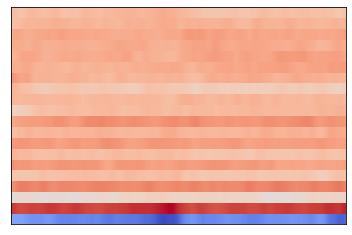

In [ ]:
librosa.display.specshow(X_train_mfcc[0].T)

In [ ]:
np.save("gdrive/MyDrive/CSE5368/gtzan_X_train_mfcc.npy", X_train_mfcc)
np.save("gdrive/MyDrive/CSE5368/gtzan_X_test_mfcc.npy", X_test_mfcc)
np.save("gdrive/MyDrive/CSE5368/gtzan_X_valid_mfcc.npy", X_valid_mfcc)
np.save("gdrive/MyDrive/CSE5368/gtzan_y_train_mfcc.npy", y_train_mfcc)
np.save("gdrive/MyDrive/CSE5368/gtzan_y_test_mfcc.npy", y_test_mfcc)
np.save("gdrive/MyDrive/CSE5368/gtzan_y_valid_mfcc.npy", y_valid_mfcc)

In [ ]:
X_train_mfcc = np.load("gdrive/MyDrive/CSE5368/gtzan_X_train_mfcc.npy")
X_test_mfcc = np.load("gdrive/MyDrive/CSE5368/gtzan_X_test_mfcc.npy")
X_valid_mfcc = np.load("gdrive/MyDrive/CSE5368/gtzan_X_valid_mfcc.npy")
y_train_mfcc = np.load("gdrive/MyDrive/CSE5368/gtzan_y_train_mfcc.npy")
y_test_mfcc = np.load("gdrive/MyDrive/CSE5368/gtzan_y_test_mfcc.npy")
y_valid_mfcc = np.load("gdrive/MyDrive/CSE5368/gtzan_y_valid_mfcc.npy")

In [ ]:
y_train_mfcc_category = to_categorical(y_train_mfcc)
y_test_mfcc_category = to_categorical(y_test_mfcc)
y_valid_mfcc_category = to_categorical(y_valid_mfcc)

In [ ]:
inputShape = (None,  20)
inputLayer = Input(shape=inputShape)

#Input Layer
layer = inputLayer

# Convolutional Layers
for i in range(3):
  layer = Conv1D(filters=3, kernel_size=5)(layer)
  layer = BatchNormalization()(layer)
  layer = Activation('relu')(layer)
  layer = MaxPooling1D(2)(layer)

# LSTM Layers
layer = LSTM(96, return_sequences=True)(layer)
layer = LSTM(64)(layer)

# Fully connected layers
layer = Dense(32)(layer)
layer = Dense(10)(layer)

# Output Layer
layer = Activation('softmax')(layer)

pred = layer

model = Model(inputs=inputLayer, outputs=pred)

opt = RMSprop(lr=0.00075)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, 20)]        0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 3)           303       
_________________________________________________________________
batch_normalization_6 (Batch (None, None, 3)           12        
_________________________________________________________________
activation_8 (Activation)    (None, None, 3)           0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, None, 3)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 3)           48        
_________________________________________________________________
batch_normalization_7 (Batch (None, None, 3)           12  

In [ ]:
history = model.fit(x=X_train_mfcc, y=y_train_mfcc_category, batch_size=32, epochs=75, validation_data=(X_valid_mfcc, y_valid_mfcc_category), verbose=True)

Epoch 1/75
18/18 [==============================] - 3s 90ms/step - loss: 2.2274 - accuracy: 0.2290 - val_loss: 2.3300 - val_accuracy: 0.0500
Epoch 2/75
18/18 [==============================] - 0s 18ms/step - loss: 2.0424 - accuracy: 0.2773 - val_loss: 2.7286 - val_accuracy: 0.0857
Epoch 3/75
18/18 [==============================] - 0s 17ms/step - loss: 1.9889 - accuracy: 0.2898 - val_loss: 2.4915 - val_accuracy: 0.0857
Epoch 4/75
18/18 [==============================] - 0s 18ms/step - loss: 1.9470 - accuracy: 0.2987 - val_loss: 2.6689 - val_accuracy: 0.0857
Epoch 5/75
18/18 [==============================] - 0s 17ms/step - loss: 1.9397 - accuracy: 0.2987 - val_loss: 2.7569 - val_accuracy: 0.0857
Epoch 6/75
18/18 [==============================] - 0s 18ms/step - loss: 1.9043 - accuracy: 0.3059 - val_loss: 2.6535 - val_accuracy: 0.0857
Epoch 7/75
18/18 [==============================] - 0s 17ms/step - loss: 1.8615 - accuracy: 0.3256 - val_loss: 2.5772 - val_accuracy: 0.0929
Epoch 8/75
18

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


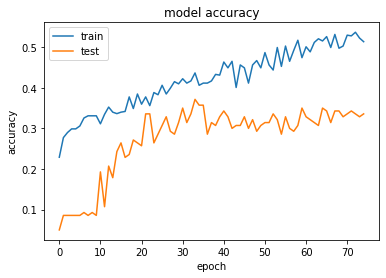

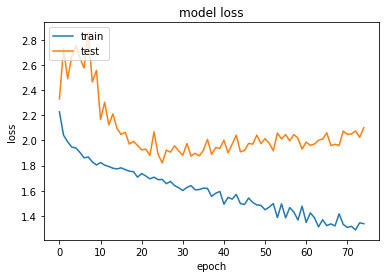

In [ ]:
def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

show_summary_stats(history)

In [ ]:
score = model.evaluate(X_test_mfcc, y_test_mfcc_category)

print("Loss")
print(score[0])
print("Acc")
print(score[1])

10/10 [==============================] - 0s 8ms/step - loss: 2.0619 - accuracy: 0.3200
Loss
2.06191086769104
Acc
0.3199999928474426


In [ ]:
from sklearn.metrics import classification_report

y_true = y_test_mfcc
y_pred = model.predict(X_test_mfcc)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4,5,6,7,8,9]
target_names = genreID.keys()

In [ ]:
print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

(300, 1) (300,)
              precision    recall  f1-score   support

       blues       0.06      0.03      0.04        30
   classical       0.61      0.63      0.62        30
     country       0.26      0.20      0.23        30
       disco       0.22      0.23      0.23        30
      hiphop       0.32      0.23      0.27        30
        jazz       0.34      0.57      0.42        30
       metal       0.41      0.80      0.55        30
         pop       0.41      0.23      0.30        30
      reggae       0.29      0.13      0.18        30
        rock       0.11      0.13      0.12        30

    accuracy                           0.32       300
   macro avg       0.30      0.32      0.30       300
weighted avg       0.30      0.32      0.30       300



In [ ]:
mfccs = np.empty((0, 259, 20))

trackGenreIDs = []

samplesPerTrack = 22050 * 30
samplesPerSegment = int(samplesPerTrack / 5)
mfccPerSegment = math.ceil(samplesPerSegment / 512)

i = 0
for path in filePaths:
  with warnings.catch_warnings():
    try:
      warnings.simplefilter("ignore")
      for j in range(5):
        mfcc = createMFCC(path, True, j)
        if(len(mfcc) == mfccPerSegment):
          mfccs = np.append(mfccs, [mfcc], axis=0)
          trackGenreIDs.append(genreID[trackGenres[i]])
    except:
      continue
  i += 1
  
print(len(mfccs))

In [ ]:
XMFCC5 = mfccs
yMFCC5 = np.array(trackGenreIDs)

print(XMFCC5.shape)
print(yMFCC5.shape)

(997, 259, 20)
(997, 1)


In [ ]:
np.save("gdrive/MyDrive/CSE5368/gtzan_X_mfcc5.npy", XMFCC5)
np.save("gdrive/MyDrive/CSE5368/gtzan_y_mfcc5.npy", yMFCC5)

In [ ]:
XMFCC5 = np.load("gdrive/MyDrive/CSE5368/gtzan_X_mfcc5.npy")
yMFCC5 = np.load("gdrive/MyDrive/CSE5368/gtzan_y_mfcc5.npy")

In [ ]:
X_train_mfcc5, X_test_mfcc5, y_train_mfcc5, y_test_mfcc5 = train_test_split(XMFCC5, yMFCC5, test_size=0.3, stratify=yMFCC5)

In [ ]:
X_train_mfcc5, X_valid_mfcc5, y_train_mfcc5, y_valid_mfcc5 = train_test_split(X_train_mfcc5, y_train_mfcc5, test_size=0.2)

In [ ]:
librosa.display.specshow(X_train_mfcc[0].T)

In [ ]:
np.save("gdrive/MyDrive/CSE5368/gtzan_X_train_mfcc.npy5", X_train_mfcc5)
np.save("gdrive/MyDrive/CSE5368/gtzan_X_test_mfcc.npy5", X_test_mfcc5)
np.save("gdrive/MyDrive/CSE5368/gtzan_X_valid_mfcc.npy5", X_valid_mfcc5)
np.save("gdrive/MyDrive/CSE5368/gtzan_y_train_mfcc.npy5", y_train_mfcc5)
np.save("gdrive/MyDrive/CSE5368/gtzan_y_test_mfcc.npy5", y_test_mfcc5)
np.save("gdrive/MyDrive/CSE5368/gtzan_y_valid_mfcc.npy5", y_valid_mfcc5)

In [ ]:
X_train_mfcc = np.load("gdrive/MyDrive/CSE5368/gtzan_X_train_mfcc.npy")
X_test_mfcc = np.load("gdrive/MyDrive/CSE5368/gtzan_X_test_mfcc.npy")
X_valid_mfcc = np.load("gdrive/MyDrive/CSE5368/gtzan_X_valid_mfcc.npy")
y_train_mfcc = np.load("gdrive/MyDrive/CSE5368/gtzan_y_train_mfcc.npy")
y_test_mfcc = np.load("gdrive/MyDrive/CSE5368/gtzan_y_test_mfcc.npy")
y_valid_mfcc = np.load("gdrive/MyDrive/CSE5368/gtzan_y_valid_mfcc.npy")

In [ ]:
y_train_mfcc_category5 = to_categorical(y_train_mfcc5)
y_test_mfcc_category5 = to_categorical(y_test_mfcc5)
y_valid_mfcc_category5 = to_categorical(y_valid_mfcc5)

In [ ]:
inputShape = (None,  20)
inputLayer = Input(shape=inputShape)

#Input Layer
layer = inputLayer

# Convolutional Layers
for i in range(3):
  layer = Conv1D(filters=3, kernel_size=5)(layer)
  layer = BatchNormalization()(layer)
  layer = Activation('relu')(layer)
  layer = MaxPooling1D(2)(layer)

# LSTM Layers
layer = LSTM(96, return_sequences=True)(layer)
layer = LSTM(64)(layer)

# Fully Connected Layers
layer = Dense(32)(layer)
layer = Dense(10)(layer)

#Output Layer
layer = Activation('softmax')(layer)

pred = layer

model = Model(inputs=inputLayer, outputs=pred)

opt = RMSprop(lr=0.00075)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, None, 20)]        0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, None, 3)           303       
_________________________________________________________________
batch_normalization_9 (Batch (None, None, 3)           12        
_________________________________________________________________
activation_12 (Activation)   (None, None, 3)           0         
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, None, 3)           0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, None, 3)           48        
_________________________________________________________________
batch_normalization_10 (Batc (None, None, 3)           12  

In [ ]:
history = model.fit(x=X_train_mfcc5, y=y_train_mfcc_category5, batch_size=128, epochs=75, validation_data=(X_valid_mfcc5, y_valid_mfcc_category5), verbose=True)

Epoch 1/75
5/5 [==============================] - 4s 235ms/step - loss: 2.2865 - accuracy: 0.1444 - val_loss: 2.3825 - val_accuracy: 0.1000
Epoch 2/75
5/5 [==============================] - 0s 20ms/step - loss: 2.1915 - accuracy: 0.1711 - val_loss: 2.2407 - val_accuracy: 0.1357
Epoch 3/75
5/5 [==============================] - 0s 21ms/step - loss: 2.0634 - accuracy: 0.2336 - val_loss: 2.1645 - val_accuracy: 0.1714
Epoch 4/75
5/5 [==============================] - 0s 22ms/step - loss: 2.0368 - accuracy: 0.2758 - val_loss: 2.1708 - val_accuracy: 0.1714
Epoch 5/75
5/5 [==============================] - 0s 20ms/step - loss: 1.9471 - accuracy: 0.2885 - val_loss: 2.2634 - val_accuracy: 0.2143
Epoch 6/75
5/5 [==============================] - 0s 22ms/step - loss: 1.9161 - accuracy: 0.3105 - val_loss: 2.0448 - val_accuracy: 0.2786
Epoch 7/75
5/5 [==============================] - 0s 21ms/step - loss: 1.8794 - accuracy: 0.3270 - val_loss: 2.0687 - val_accuracy: 0.2786
Epoch 8/75
5/5 [==========

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


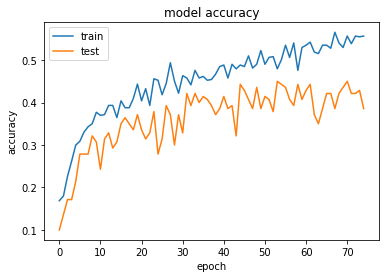

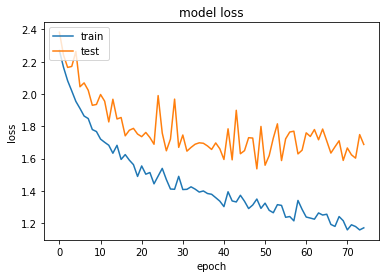

In [ ]:
def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

show_summary_stats(history)

In [ ]:
score = model.evaluate(X_test_mfcc5, y_test_mfcc_category5)

print("Loss")
print(score[0])
print("Acc")
print(score[1])

10/10 [==============================] - 0s 5ms/step - loss: 1.7364 - accuracy: 0.3700
Loss
1.7363706827163696
Acc
0.3700000047683716


In [ ]:
from sklearn.metrics import classification_report

y_true = y_test_mfcc5
y_pred = model.predict(X_test_mfcc5)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4,5,6,7,8,9]
target_names = genreID.keys()

In [ ]:
print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

(300, 1) (300,)
              precision    recall  f1-score   support

       blues       0.19      0.33      0.24        30
   classical       0.83      0.80      0.81        30
     country       0.28      0.50      0.36        30
       disco       0.31      0.37      0.34        30
      hiphop       0.38      0.20      0.26        30
        jazz       0.42      0.37      0.39        30
       metal       1.00      0.13      0.24        30
         pop       0.65      0.67      0.66        30
      reggae       0.23      0.27      0.25        30
        rock       0.11      0.07      0.08        30

    accuracy                           0.37       300
   macro avg       0.44      0.37      0.36       300
weighted avg       0.44      0.37      0.36       300

